In [5]:
import pandas as pd
training_dataframe = pd.DataFrame()
train_files = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426','06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378']
#train_files = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261','08405', '08434', '08455', '07162', '07859', '07879', '07910', '08215', '08219', '08378']
for file in train_files:
    df = pd.read_csv(f'data/proccessed/{file}.csv', header=None)
    #df = pd.read_csv(f'data/proccessed_tmp/{file}_label_100_data.csv', header=None)
    #df = pd.read_csv(f'data/proccessed_cleaned/{file}.csv', header=None)
    training_dataframe = pd.concat([training_dataframe, df], ignore_index=True)
    
    
#training_dataframe.to_csv(f'data/proccessed_cleaned/train.csv', index=False, header=False)
#training_dataframe.to_csv(f'data/proccessed_tmp/train.csv', index=False, header=False)
training_dataframe.to_csv(f'data/proccessed/train.csv', index=False, header=False)







In [7]:
test_dataframe = pd.DataFrame()
test_files = ['08405', '08434', '08455']
#test_files = ['06426', '06453', '06995']
for file in test_files:
    df = pd.read_csv(f'data/proccessed/{file}.csv', header=None)
    #df = pd.read_csv(f'data/proccessed_tmp/{file}_label_100_data.csv', header=None)
    #df = pd.read_csv(f'data/proccessed_cleaned/{file}.csv', header=None)
    test_dataframe = pd.concat([test_dataframe, df], ignore_index=True)
    
#test_dataframe.to_csv(f'data/proccessed_cleaned/test.csv', index=False, header=False)
#test_dataframe.to_csv(f'data/proccessed_tmp/test.csv', index=False, header=False)
test_dataframe.to_csv(f'data/proccessed/test.csv', index=False, header=False)

In [2]:
import torch
import pandas as pd

%load_ext autoreload
%autoreload 2

#training_dataframe = pd.read_csv(f'data/proccessed/train.csv', header=None)
#test_dataframe = pd.read_csv(f'data/proccessed/test.csv', header=None)
#label_col = 100
label_col = 0
training_dataframe = pd.read_csv(f'data/proccessed_tmp/train.csv', header=None)
test_dataframe = pd.read_csv(f'data/proccessed_tmp/test.csv', header=None)

# training_dataframe = pd.read_csv(f'data/proccessed_cleaned/train.csv', header=None)
# test_dataframe = pd.read_csv(f'data/proccessed_cleaned/test.csv', header=None)


training_dataframe[label_col][training_dataframe[0] > 0] = 1
test_dataframe[label_col][test_dataframe[0] > 0] = 1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [3]:
from neural_network.model import *
from neural_network.dataloader import MySampler
from neural_network.params import model_params

batch_size = model_params['batch_size']
train_test_ratio = 0.9 
print(batch_size)



labels = training_dataframe[label_col]
samples = training_dataframe.drop(training_dataframe.columns[label_col], axis=1)
beats_num = samples.shape[1]
num_samples = samples.shape[0]




train_samples = torch.tensor(samples.values).reshape(num_samples, beats_num)#.to(device=device)
train_labels = torch.tensor(labels.values).reshape(num_samples, 1)#.to(device=device)
train_dataset = torch.FloatTensor(samples.values)#.to(device=device)

num_train = int(train_test_ratio * num_samples)
num_valid = int((1 - train_test_ratio) * num_samples)

ds_train = torch.utils.data.TensorDataset(train_dataset[:num_train],train_labels[:num_train])
#ds_train = torch.utils.data.TensorDataset(train_dataset[num_valid:],train_labels[num_valid:])
train_sampler = MySampler(ds_train, batch_size)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,sampler=train_sampler ,shuffle = False, drop_last=True)
#dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,shuffle = False, drop_last=True)


ds_valid = torch.utils.data.TensorDataset(train_dataset[num_train:],train_labels[num_train:])
#ds_valid = torch.utils.data.TensorDataset(train_dataset[:num_valid],train_labels[:num_valid])
valid_sampler = MySampler(ds_valid, batch_size)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=batch_size,sampler=valid_sampler ,shuffle = False, drop_last=True)
#dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=batch_size ,shuffle = False, drop_last=True)



non_afs = sum(labels == 0)
afs =sum(labels == 1)


1024


In [4]:
print(afs)
print(non_afs)

438022
530281


In [17]:
import torch.nn as nn
import torch.optim as optim
from neural_network.training import RNNTrainer
from neural_network.params import model_params
from neural_network.model import *

torch.manual_seed(42)
num_epochs = 20

loss_func = nn.BCELoss()
m = Model(lstm_drop=model_params['dropout_lstm'],  layers=model_params['layers'], device=device)
m = m.to(device)

optimizer = optim.Adam(m.parameters(), lr=model_params['lr'])

trainer = RNNTrainer(m, loss_func, optimizer, device)

In [18]:
# Train, unless final checkpoint is found
import os
checkpoint_file = 'check_af'
early_stopping = 20
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    m.load_state_dict(saved_state['model_state'])
else:
    try:
        fit_res = trainer.fit(dl_train, dl_valid, num_epochs, max_batches=None,
                              early_stopping=early_stopping,
                              checkpoints=checkpoint_file, print_every=2)
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

--- EPOCH 1/20 ---
train_batch (Avg. Loss 0.268, Accuracy 88.7): 100%|█| 851/851 [00:27<00:00, 30.
test_batch (Avg. Loss 0.451, Accuracy 76.5): 100%|█| 94/94 [00:01<00:00, 61.65i
--- EPOCH 3/20 ---
train_batch (Avg. Loss 0.259, Accuracy 89.8): 100%|█| 851/851 [00:27<00:00, 30.
test_batch (Avg. Loss 0.433, Accuracy 75.9): 100%|█| 94/94 [00:01<00:00, 62.24i
--- EPOCH 5/20 ---
train_batch (Avg. Loss 0.313, Accuracy 86.8): 100%|█| 851/851 [00:27<00:00, 31.
test_batch (Avg. Loss 0.882, Accuracy 53.8): 100%|█| 94/94 [00:01<00:00, 62.89i
--- EPOCH 7/20 ---
train_batch (Avg. Loss 0.254, Accuracy 90.0): 100%|█| 851/851 [00:27<00:00, 30.
test_batch (Avg. Loss 0.614, Accuracy 68.7): 100%|█| 94/94 [00:01<00:00, 63.23i
--- EPOCH 9/20 ---
train_batch (Avg. Loss 0.271, Accuracy 89.2): 100%|█| 851/851 [00:27<00:00, 30.
test_batch (Avg. Loss 0.894, Accuracy 69.8): 100%|█| 94/94 [00:01<00:00, 63.04i
--- EPOCH 11/20 ---
train_batch (Avg. Loss 0.294, Accuracy 87.6): 100%|█| 851/851 [00:27<00:00, 31.
test_

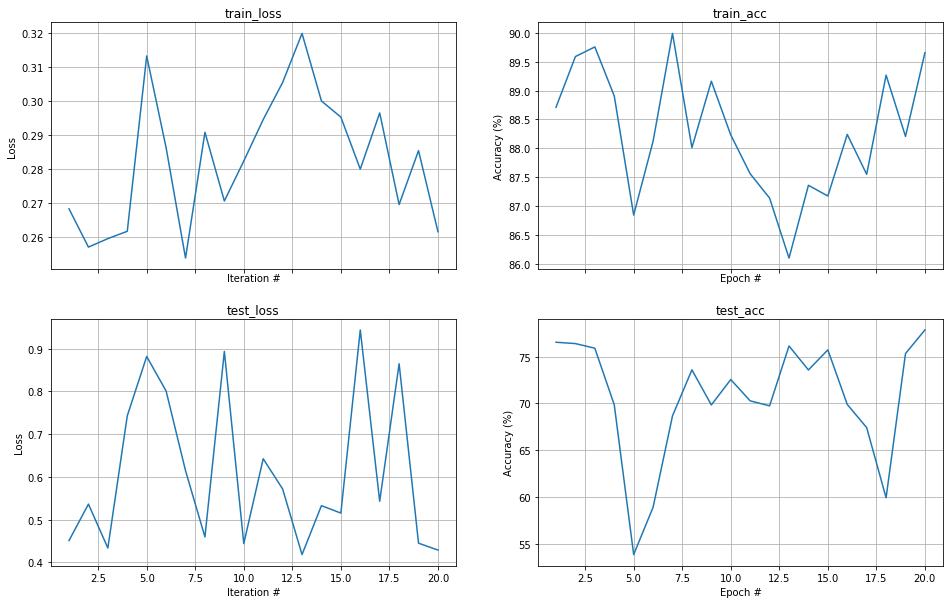

In [19]:
from cs236781.plot import plot_fit
fig, axes = plot_fit(fit_res)

TEST

In [20]:
#saved_state = torch.load('check_af_lr_e4_drop01_batch1024_layer_2.pt', map_location=device)
#m.load_state_dict(saved_state['model_state'])
#test_dataframe = pd.read_csv(f'data/proccessed_cleaned/test.csv', header=None)
test_dataframe = pd.read_csv(f'data/proccessed_tmp/test.csv', header=None)
labels = training_dataframe[label_col]
samples = training_dataframe.drop(training_dataframe.columns[label_col], axis=1)
beats_num = samples.shape[1]
num_samples = samples.shape[0]

test_samples = torch.tensor(samples.values).reshape(num_samples, beats_num)#.to(device=device)
test_labels = torch.tensor(labels.values).reshape(num_samples, 1)#.to(device=device)
test_dataset = torch.FloatTensor(samples.values)#.to(device=device)


ds_test = torch.utils.data.TensorDataset(test_dataset,test_labels)
test_sampler = MySampler(ds_test, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle = False)#, drop_last=True,sampler=test_sampler, )


In [21]:
h = None
running_loss = 0.0
num_correct = 0
num_correct_total = 0 
true_negative = 0
true_possitive = 0
false_possitive = 0
false_negative = 0
m.train(False)
for i, data in enumerate(dl_test):
    inputs, labels = data
    inputs = inputs.to(device=device, dtype=torch.float32).unsqueeze(1)
    labels = labels.to(device=device, dtype=torch.float32).unsqueeze(1)
    y, h = m(inputs, h)
    loss = loss_func(y, labels)
    predict_y = y.round()
    num_correct = torch.sum(predict_y == labels)
    num_correct_total += num_correct
    true_pos = torch.sum((labels == 0) & (predict_y == 0)) # no AF and predicted no AF
    true_neg = torch.sum((labels == 1) & (predict_y == 1)) #  AF and predicted  AF
    false_pos = torch.sum((labels == 1) & (predict_y == 0)) #  AF and predicted no AF
    false_neg = torch.sum((labels == 0) & (predict_y == 1)) #  no AF and predicted  AF
    
    true_negative+=true_neg
    true_possitive+=true_pos
    false_negative+=false_neg
    false_possitive+=false_pos

    assert(true_neg + true_pos == num_correct)

    # print statistics
    running_loss += loss.item()

print('Finished Training')

Finished Training


In [22]:
print(f"acc : {float(num_correct_total) / (batch_size * len(dl_test))}")
print(true_negative, true_possitive, false_possitive ,false_negative)
print(f"loss: {float(running_loss) / len(dl_test)}")

acc : 0.5746853528012685
tensor(50449, device='cuda:0') tensor(506251, device='cuda:0') tensor(387573, device='cuda:0') tensor(24030, device='cuda:0')
loss: 1.8802398826472346


In [23]:
print(float(true_negative)/ (float(true_negative) + false_possitive))

tensor(0.1152, device='cuda:0')


In [24]:
print(float(true_possitive)/ (float(true_possitive) + false_negative))

tensor(0.9547, device='cuda:0')
